In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene

import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

2024-06-06 20:28:13,774	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Do a backup of the data

# Multiply every resource by a factor of 10
# Always check for one dimensional arrays

new_data = copy.deepcopy(data)

FACTOR = 1

# Generators
for key in new_data.generator.keys():

    # Check if the array is one dimensional
    if len(new_data.generator[key].shape) == 1:
        new_data.generator[key] = np.tile(new_data.generator[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.generator[key] = np.tile(new_data.generator[key], (FACTOR, 1))

    # Add some noise to the GenActivePower
    if key == 'genActPower':
        new_data.generator[key] = new_data.generator[key] + np.random.normal(0, 0.1, len(new_data.generator[key])) if new_data.generator[key] > 0 else 0

# Loads
for key in new_data.load.keys():

    # Check if the array is one dimensional
    if len(new_data.load[key].shape) == 1:
        new_data.load[key] = np.tile(new_data.load[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.load[key] = np.tile(new_data.load[key], (FACTOR, 1))

    # Add some noise to the LoadActivePower
    if key == 'loadActPower':
        new_data.load[key] = new_data.load[key] + np.random.normal(0, 0.1, len(new_data.load[key])) if new_data.load[key] > 0 else 0

# Storages
for key in new_data.storage.keys():

    # Check if the array is one dimensional
    if len(new_data.storage[key].shape) == 1:
        new_data.storage[key] = np.tile(new_data.storage[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.storage[key] = np.tile(new_data.storage[key], (FACTOR, 1))

# EVs
for key in new_data.vehicle.keys():

    # Check if the array is one dimensional
    if len(new_data.vehicle[key].shape) == 1:
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (FACTOR, ))
    else:
        # Add in n times
        new_data.vehicle[key] = np.tile(new_data.vehicle[key], (FACTOR, 1))

# Increase the import and export maximum values by a factor of 10 to keep up
new_data.peers['import_contracted_p_max'] = new_data.peers['import_contracted_p_max'] * FACTOR
new_data.peers['export_contracted_p_max'] = new_data.peers['export_contracted_p_max'] * FACTOR

# Do a backup of the data
data_backup = copy.deepcopy(data)

# Assign the new data to original data
data = copy.deepcopy(new_data)

In [4]:
new_data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [5]:
# Define generators
gens = Generator(name='gens',
                 value=np.zeros(data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(data.generator['p_forecast'].shape),
                 upper_bound=data.generator['p_forecast'],
                 cost=data.generator['cost_parameter_b'],
                 cost_nde=data.generator['cost_nde'],
                 is_renewable=data.generator['type_generator'])

# Define loads
loads = Load(name='loads',
             value=data.load['p_forecast'],
             lower_bound=np.zeros(data.load['p_forecast'].shape),
             upper_bound=data.load['p_forecast'],
             cost=np.ones(data.load['p_forecast'].shape),
             cost_cut=data.load['cost_cut'],
             cost_reduce=data.load['cost_reduce'],
             cost_ens=data.load['cost_ens'])

# Define storage
stor = Storage(name='stor',
               value=np.zeros(data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(data.storage['p_charge_limit'].shape),
               upper_bound=(data.storage['energy_capacity'] *
                            np.ones(data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(data.storage['p_charge_limit'].shape),
               cost_discharge=data.storage['discharge_price'],
               cost_charge=data.storage['charge_price'],
               capacity_max=data.storage['energy_capacity'],
               capacity_min=data.storage['energy_min_percentage'],
               initial_charge=data.storage['initial_state'],
               discharge_efficiency=data.storage['discharge_efficiency'],
               discharge_max=data.storage['p_discharge_limit'],
               charge_efficiency=data.storage['charge_efficiency'],
               charge_max=data.storage['p_charge_limit'],
               capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), FACTOR))

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(data.vehicle['schedule_charge'].shape),
              lower_bound=(data.vehicle['e_capacity_max'] * data.vehicle['min_technical_soc'] *
                           np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(data.vehicle['e_capacity_max'] * np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(data.vehicle['schedule_charge'].shape),
              cost_discharge=data.vehicle['discharge_price'][:, 0],
              cost_charge=data.vehicle['charge_price'][:, 0],
              capacity_max=data.vehicle['e_capacity_max'],
              initial_charge=np.ones(data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=data.vehicle['min_technical_soc'],
              discharge_efficiency=data.vehicle['discharge_efficiency'],
              charge_efficiency=data.vehicle['charge_efficiency'],
              capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), FACTOR),
              schedule_discharge=data.vehicle['schedule_discharge'],
              schedule_charge=data.vehicle['schedule_charge'])

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['import_contracted_p_max'][0, :],
                      cost=data.peers['buy_price'][0, :],
                      is_active=np.zeros(data.peers['import_contracted_p_max'][0, :].shape))

pexp = BinaryResource(name='pExp',
                      value=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['export_contracted_p_max'][0, :],
                      cost=data.peers['sell_price'][0, :],
                      is_active=np.zeros(data.peers['export_contracted_p_max'][0, :].shape))

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [6]:
data.generator.keys()

dict_keys(['p_forecast', 'cost_parameter_a', 'cost_parameter_b', 'cost_parameter_c', 'cost_nde', 'ghg_cof_a', 'ghg_cof_b', 'ghg_cof_c', 'internal_bus_location', 'type_generator', 'owner', 'manager', 'type_contract', 'p_max', 'p_min', 'q_max', 'q_min'])

In [7]:
# Create an initial solution

sol_shaped = {'genActPower': data.generator['p_forecast'],
              'genExcActPower': np.zeros(data.generator['p_forecast'].shape),
              'pImp': data.peers['import_contracted_p_max'][0, :],
              'pExp': np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
              'loadRedActPower': np.zeros(data.load['p_forecast'].shape),
              'loadCutActPower': np.zeros(data.load['p_forecast'].shape),
              'loadENS': np.zeros(data.load['p_forecast'].shape),
              'storDchActPower': np.zeros(data.storage['p_charge_limit'].shape),
              'storChActPower': np.zeros(data.storage['p_charge_limit'].shape),
              'EminRelaxStor': np.zeros(data.storage['p_charge_limit'].shape),
              'storEnerState': np.zeros(data.storage['p_charge_limit'].shape),
              'v2gDchActPower': np.zeros(data.vehicle['schedule_charge'].shape),
              'v2gChActPower': np.zeros(data.vehicle['schedule_charge'].shape),
              'EminRelaxEV': np.zeros(data.vehicle['schedule_charge'].shape),
              'v2gEnerState': np.zeros(data.vehicle['schedule_charge'].shape),
              #'csActPower': np.zeros(data.charging_station['p_charge_limit'].shape),
              #'csActPowerNet': np.zeros(data.charging_station['p_charge_limit'].shape),
              'genXo': np.zeros(data.generator['p_forecast'].shape),
              'loadXo': np.zeros(data.load['p_forecast'].shape),
              'storDchXo': np.ones(data.storage['p_charge_limit'].shape),
              'storChXo': np.zeros(data.storage['p_charge_limit'].shape),
              'v2gDchXo': np.zeros(data.vehicle['schedule_charge'].shape),
              'v2gChXo': np.zeros(data.vehicle['schedule_charge'].shape)}

In [44]:
# Create the scene

NAME = 'mgo_run10'
scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=data, pop_size=20,
                       n_iter=20000, iter_tolerance=1000,
                       deterministic_vehicles=True,
                       initial_solution=None)
scene.initialize()
scene.run(algorithm='mgo')

100%|██████████| 20000/20000 [41:08<00:00,  8.10it/s]


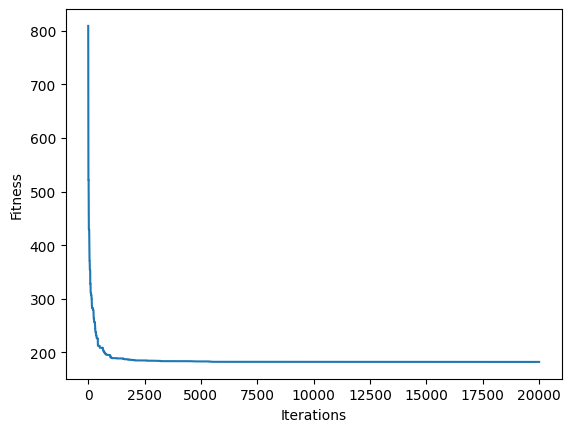

In [45]:
# Plot the fitness evolution

plt.plot(scene.algo.population_history_fitness)
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.show()

In [46]:
# Build the DataFrames for an easy area visualization
# For this we'll consider the sum of each component over time

def concat_resources(data, load_data):

    consumptions = pd.DataFrame({}, index=['{:02d}:00'.format(i) for i in np.arange(24)])
    consumptions['Loads'] = np.sum(load_data, axis=0)
    consumptions['Generator Excess'] = np.sum(data['genExcActPower'], axis=0)
    consumptions['Storage Charge'] = np.sum(data['storChActPower'], axis=0)
    consumptions['Vehicle Charge'] = np.sum(data['v2gChActPower'], axis=0)
    consumptions['Exports'] = data['pExp']

    productions = pd.DataFrame({}, index=['{:02d}:00'.format(i) for i in np.arange(24)])
    productions['Generator'] =np.sum(data['genActPower'], axis=0)
    productions['Load Cut'] = np.sum(data['loadCutActPower'], axis=0)
    productions['Load Reduce'] = np.sum(data['loadRedActPower'], axis=0)
    productions['Energy Not Supplied'] = np.sum(data['loadENS'], axis=0)
    productions['Storage Discharge'] = np.sum(data['storDchActPower'], axis=0)
    productions['Vehicle Discharge'] = np.sum(data['v2gDchActPower'], axis=0)
    productions['Imports'] = data['pImp']

    return consumptions, productions

In [47]:
# Get the DataFrames

consumptions, productions = concat_resources(scene.current_best, data.load['p_forecast'])

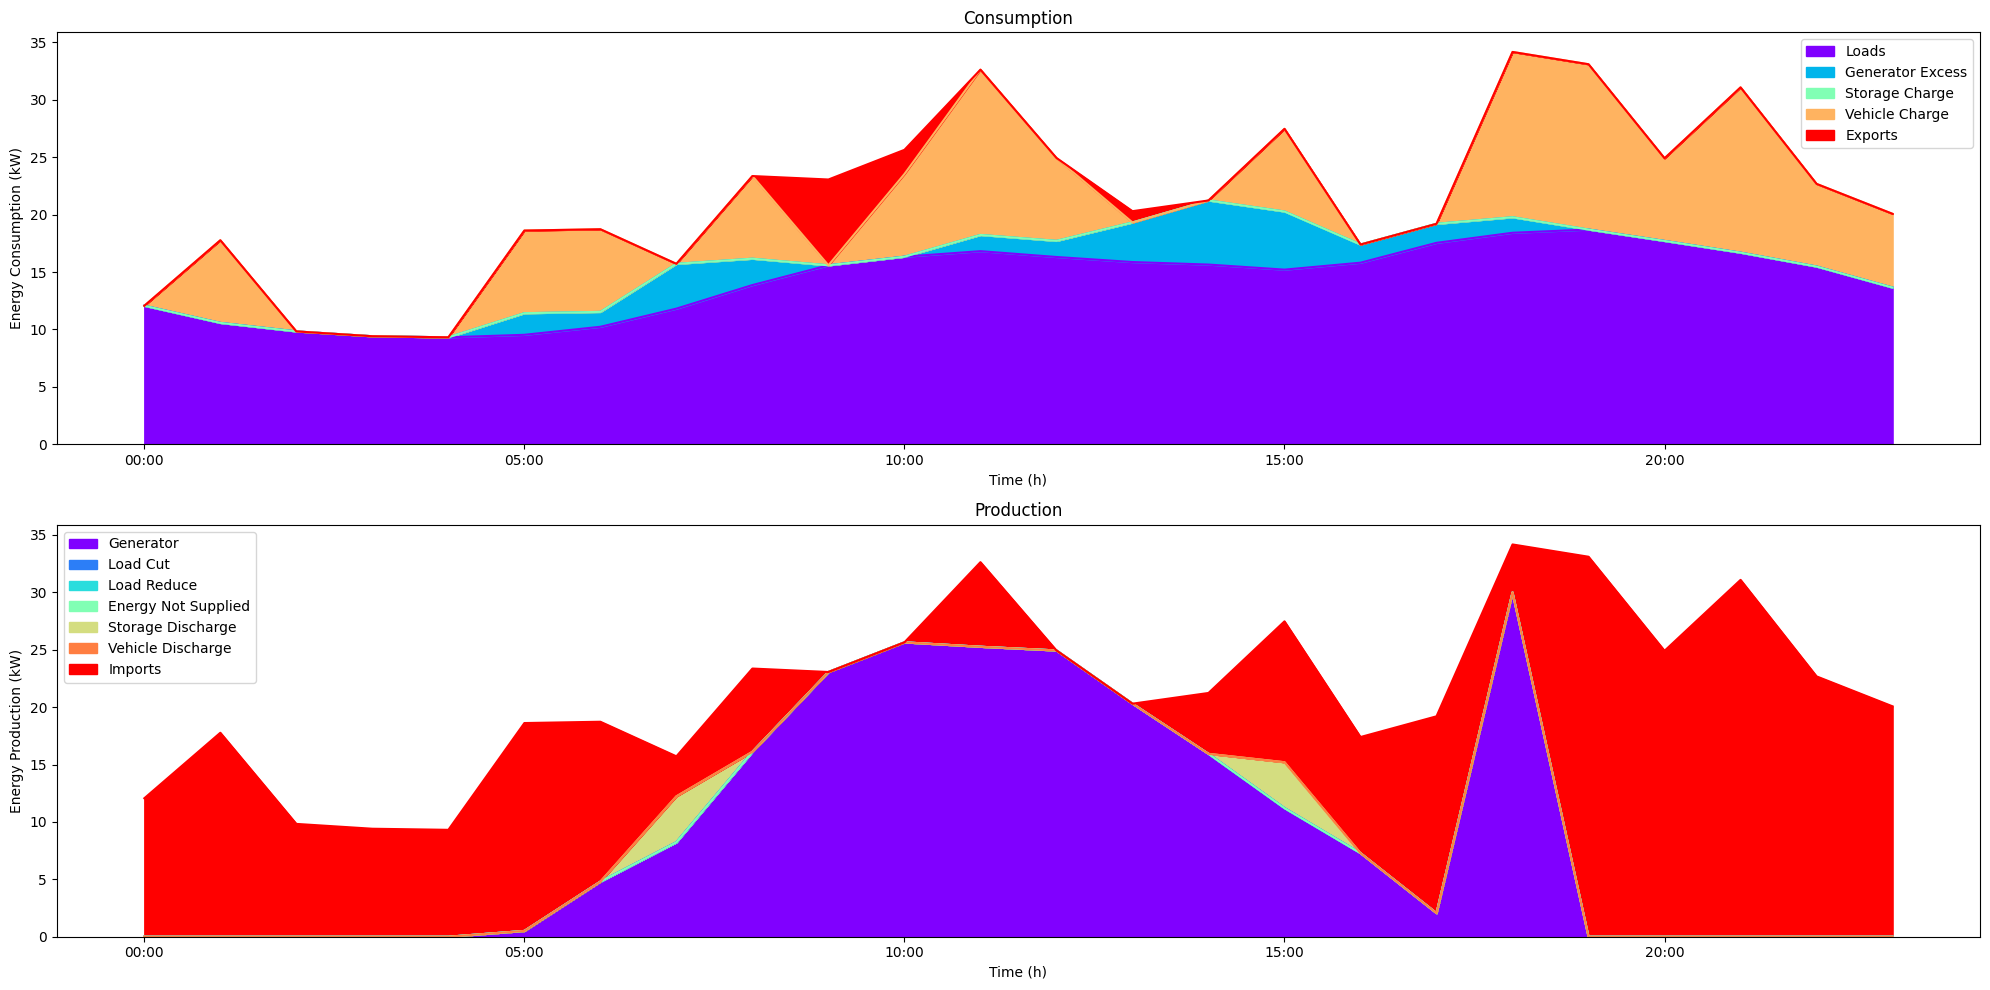

In [48]:
# Plot the HyDE-DF cons and prods

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

consumptions.plot.area(ax=axs[0], cmap='rainbow')
axs[0].set_title('Consumption')
axs[0].set_ylabel('Energy Consumption (kW)')
axs[0].set_xlabel('Time (h)')

productions.plot.area(ax=axs[1], cmap='rainbow')
axs[1].set_title('Production')
axs[1].set_ylabel('Energy Production (kW)')
axs[1].set_xlabel('Time (h)')

plt.tight_layout()

# plt.savefig('results_hyde.svg')

plt.show()

In [49]:
# Create a folder for each experiment of the algorithm

if not os.path.exists('results_v2/' + NAME):
    os.makedirs('results_v2/' + NAME)
    
# Save the results
for key in scene.current_best.keys():
    save_path = 'results_v2/' + NAME + '/' + key + '.csv'
    pd.DataFrame(scene.current_best[key]).to_csv(save_path)
    
# Create a DataFrame with the average fitness of the population, the best fitness and time
temp_df = pd.DataFrame({'population_fitness': np.mean(scene.algo.population_fitness),
                        'best_fitness': scene.current_best_fitness,
                        'time': scene.run_time}, index=[0])

# Save the DataFrame
temp_df.to_csv('results_v2/' + NAME + '/fitness.csv')

# Save the population evolution
pd.DataFrame(scene.algo.population_history_fitness).to_csv('results_v2/' + NAME + '/fitness_evolution.csv')